In [1]:
import matplotlib.pyplot as plt

import ROOT, root_pandas, root_numpy, numpy
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


# import necessary keras modules/functions
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Flatten, Dense, Dropout, MaxPooling2D
from keras.layers import BatchNormalization, Activation, AveragePooling2D, Concatenate

from utils import PlotLearning

Welcome to JupyROOT 6.19/01


Using TensorFlow backend.


In [2]:
file = ROOT.TFile("../FlatTree_Production/ML_Unfolding_tree_100k.root")
outTree = file.outTree
n_events = outTree.GetEntries()
n_events

54404

TFile**		../FlatTree_Production/ML_Unfolding_tree_100k.root	
 TFile*		../FlatTree_Production/ML_Unfolding_tree_100k.root	
  KEY: TTree	outTree;1	outTree
  KEY: TH1F	h_Mass_Z_gen;1	h_Mass_Z_gen
  KEY: TH1F	h_Mass_Z_reco;1	h_Mass_Z_reco


In [3]:
data = [list(i) for i in root_numpy.tree2array(outTree, start=0, stop = n_events)]

x = numpy.array([i[:-1] for i in data])
y = numpy.array([i[-1] for i in data])
len(x[0])

x = preprocessing.scale(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (43523, 25)
43523 train samples
10881 test samples


In [4]:
# Build the model

model = Sequential()

model.add(Dense(100, input_dim = 25, kernel_initializer='normal', activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()
model.compile(loss='mean_squared_logarithmic_error', optimizer='adam', metrics=['mse','mae'])

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               2600      
_________________________________________________________________
dense_2 (Dense)              (None, 80)                8080      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                1620      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 21        
Total params: 18,801
Trainable params: 18,801
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Define additional callbacks

def reduce_lr(patience_lr):
    reduce_lr_loss = keras.callbacks.ReduceLROnPlateau(monitor='val_mean_squared_error', factor=0.5, patience=patience_lr, verbose=1, min_delta=1e-4, mode='auto')
    return reduce_lr_loss

callbacks = [reduce_lr(patience_lr=20), PlotLearning()]

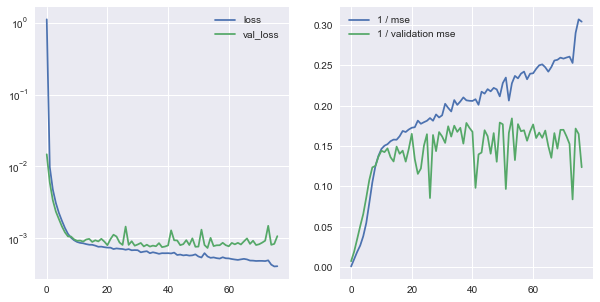

Epoch 78/200
34818/34818 [==============================] - 1s 22us/step - loss: 4.3162e-04 - mean_squared_error: 3.4765 - mean_absolute_error: 1.3067 - val_loss: 8.3456e-04 - val_mean_squared_error: 5.9822 - val_mean_absolute_error: 1.4631


In [ ]:
# Train the model
history = model.fit(x_train, y_train, epochs=200, batch_size=64,  verbose=1, validation_split=0.2, callbacks = callbacks)

In [ ]:
print(history.history.keys())
# "Loss"
plt.plot(numpy.array(history.history['mean_squared_error']))
plt.plot(numpy.array(history.history['val_mean_squared_error']))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(x_test, y_test)

In [ ]:
for i in range(20):
    print(abs(model.predict(x_train)[i]-y_train[i]))